# Porting an analysis from local to distributed

In this pair of notebooks, we will develop a prototype unsupervised analysis with sklearn and then port it to use Spark, as we might in real life.

<a href = "http://yogen.io"><img src="http://yogen.io/assets/logo.svg" alt="yogen" style="width: 200px; float: right;"/></a>

## Porting our analysis to a distributed setting using Spark DataFrames

First, read the input file

In [ ]:
from pyspark.sql import SparkSession

session = SparkSession.builder.getOrCreate()

We can specify `.read` options in two equivalent ways:

In [2]:
df = session.read.csv('sales_segments.csv.gz', sep='^', header=True)
df.show(5)

+------+------------------+------------+---------------+-----------------+-------------------+----------------+-----------------+-----------+-----------+--------------------+----------------------+--------------------+-------------------+----------+------------------+-------------+---------------+------------+-------------+---------+--------+----------------+------------------+----------------+---------------+---------+---------+------------------+--------------------+-------------+--------+--------+----------------+------------------+--------+-----------------+-------+-------+------------+-------------+-----------+--------------+--------------+---------------------+-------------------+-------------------+----------+-----------------+------------+-------+------------------+-------------+-------------------------+----------------------------+---------+----------+-----------------+------------------+
|  rloc|departure_date_seg|booking_date|freq_flyer_flag|creator_office_id|creator_iata_n

In [3]:
df = session.read\
    .option('header', 'true')\
    .option('sep', '^')\
    .csv('data/sales_segments.csv.gz')
df.show(1)

+------+------------------+------------+---------------+-----------------+-------------------+----------------+-----------------+-----------+-----------+--------------------+----------------------+--------------------+-------------------+----------+------------------+-------------+---------------+------------+-------------+---------+--------+----------------+------------------+----------------+---------------+---------+---------+------------------+--------------------+-------------+--------+-------+----------------+------------------+--------+----------------+-------+-------+------------+-------------+-----------+--------------+--------------+---------------------+-------------------+-------------------+----------+-----------------+------------+-------+------------------+-------------+-------------------------+----------------------------+---------+----------+-----------------+--------------+
|  rloc|departure_date_seg|booking_date|freq_flyer_flag|creator_office_id|creator_iata_number|

### Extract KPIs

A direct transliteration of what we did with sklearn: columnwise arithmetic

In [4]:
kpis = df.select((df['revenue_amount_seg'] / df['bookings_seg']).alias('revenue'),
                 (df['fuel_surcharge_amount_seg'] / df['bookings_seg']).alias('tax'))\
         .cache()


In [5]:
%time kpis.show(5)

+------------------+-----------------+
|           revenue|              tax|
+------------------+-----------------+
|             33.56|              7.3|
|              61.2|             25.5|
| 71.86842105263158|12.31578947368421|
|27.116666666666664|            13.31|
|               0.0|            15.91|
+------------------+-----------------+
only showing top 5 rows

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 9.6 s


In [6]:
%time kpis.show(5)

+------------------+-----------------+
|           revenue|              tax|
+------------------+-----------------+
|             33.56|              7.3|
|              61.2|             25.5|
| 71.86842105263158|12.31578947368421|
|27.116666666666664|            13.31|
|               0.0|            15.91|
+------------------+-----------------+
only showing top 5 rows

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 149 ms


## Machine Learning in Spark

### `spark.mllib` and `spark.ml`

`spark.mllib` was the original Spark Machine Learning package. It is based on RDDs. It's now on maintenance mode.

Since the focus on DataFrames, `spark.ml` is the primary ML package. It's designed around DataFrames. 

Somewhat confusingly, "Spark MLLIB" is the name of the library, and it comprises both.

https://spark.apache.org/docs/2.2.1/ml-guide.html
https://spark.apache.org/docs/2.2.1/api/python/pyspark.ml.html

### Transformers, Estimators and Models

In Spark ML, a Transformer is an object that represents a transformation from a DataFrame into another DataFrame.

Many preprocessing and feature extraction steps are represented by Transformers. In general, this happens when they don't have to learn anything from the dataset itself, which means they implement the `transform` but not the `fit` method.

When the transformation does depend on the dataset, the transformation is represented by an Estimator. An Estimator implements a `fit` method that generates a Model, which is a Transformer.

All Machine Learning models are Estimators, and many feature extraction steps are as well.

https://spark.apache.org/docs/2.2.0/ml-pipeline.html

### Assemble features

In [7]:
from pyspark.ml.feature import VectorAssembler

help(VectorAssembler)

Help on class VectorAssembler in module pyspark.ml.feature:

class VectorAssembler(pyspark.ml.wrapper.JavaTransformer, pyspark.ml.param.shared.HasInputCols, pyspark.ml.param.shared.HasOutputCol, pyspark.ml.util.JavaMLReadable, pyspark.ml.util.JavaMLWritable)
 |  A feature transformer that merges multiple columns into a vector column.
 |  
 |  >>> df = spark.createDataFrame([(1, 0, 3)], ["a", "b", "c"])
 |  >>> vecAssembler = VectorAssembler(inputCols=["a", "b", "c"], outputCol="features")
 |  >>> vecAssembler.transform(df).head().features
 |  DenseVector([1.0, 0.0, 3.0])
 |  >>> vecAssembler.setParams(outputCol="freqs").transform(df).head().freqs
 |  DenseVector([1.0, 0.0, 3.0])
 |  >>> params = {vecAssembler.inputCols: ["b", "a"], vecAssembler.outputCol: "vector"}
 |  >>> vecAssembler.transform(df, params).head().vector
 |  DenseVector([0.0, 1.0])
 |  >>> vectorAssemblerPath = temp_path + "/vector-assembler"
 |  >>> vecAssembler.save(vectorAssemblerPath)
 |  >>> loadedAssembler = Vect

In [9]:
assembler = VectorAssembler(inputCols=['revenue', 'tax'], outputCol='features')


In [15]:
newdf = assembler.transform(kpis)
newdf.show(5)

+------------------+-----------------+--------------------+
|           revenue|              tax|            features|
+------------------+-----------------+--------------------+
|             33.56|              7.3|         [33.56,7.3]|
|              61.2|             25.5|         [61.2,25.5]|
| 71.86842105263158|12.31578947368421|[71.8684210526315...|
|27.116666666666664|            13.31|[27.1166666666666...|
|               0.0|            15.91|         [0.0,15.91]|
+------------------+-----------------+--------------------+
only showing top 5 rows



In [11]:
error = assembler.transform(df)

IllegalArgumentException: 'Field "revenue" does not exist.'

### Training our model

Just like in sklearn, we use a `.fit` method. The difference is that Estimators are stateless: the software object we call kmeans doesn't learn, that is, it doesn't change its state like sklearn models do (remember the underscore-suffixed attributes of sklearn models, which are generated from the data). 

What it does is generate a new object, the one we call model, which is a Transformer. This object contains the information necessary to `.transform` our data, which is the method name spark.ml uses in place of `.predict`.

In [ ]:
from sklearn.cluster import KMeans

In [14]:
from pyspark.ml.clustering import KMeans

km_estimator = KMeans(k=8)

In [17]:
km_model = km_estimator.fit(newdf)

### Assigning clusters



In [18]:
predicted = km_model.transform(newdf)

In [26]:
predicted.show()

+------------------+-----------------+--------------------+----------+
|           revenue|              tax|            features|prediction|
+------------------+-----------------+--------------------+----------+
|             33.56|              7.3|         [33.56,7.3]|         0|
|              61.2|             25.5|         [61.2,25.5]|         0|
| 71.86842105263158|12.31578947368421|[71.8684210526315...|         0|
|27.116666666666664|            13.31|[27.1166666666666...|         0|
|               0.0|            15.91|         [0.0,15.91]|         0|
|            24.802|            12.48|      [24.802,12.48]|         0|
|           18.4275|            11.98|     [18.4275,11.98]|         0|
|              65.5|             13.0|         [65.5,13.0]|         0|
|               0.0|            15.76|         [0.0,15.76]|         0|
|              99.5|             13.0|         [99.5,13.0]|         0|
|              49.7|            10.78|        [49.7,10.78]|         0|
|     

In [25]:
predicted.groupby('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|         1|     10|
|         6|     16|
|         3|     94|
|         5|      1|
|         4| 206315|
|         7|     46|
|         2|      8|
|         0|1252631|
+----------+-------+



In [33]:
from pyspark.ml.clustering import GaussianMixture

gm_estimator = GaussianMixture(k=8)
gm_model = gm_estimator.fit(newdf)

In [34]:
predicted_by_gm = gm_model.transform(newdf)

In [35]:
predicted_by_gm.show(5)

+------------------+-----------------+--------------------+----------+--------------------+
|           revenue|              tax|            features|prediction|         probability|
+------------------+-----------------+--------------------+----------+--------------------+
|             33.56|              7.3|         [33.56,7.3]|         7|[5.12166583175723...|
|              61.2|             25.5|         [61.2,25.5]|         7|[2.76464369166838...|
| 71.86842105263158|12.31578947368421|[71.8684210526315...|         7|[3.83518157333207...|
|27.116666666666664|            13.31|[27.1166666666666...|         7|[3.66807210656433...|
|               0.0|            15.91|         [0.0,15.91]|         7|[3.31910581107735...|
+------------------+-----------------+--------------------+----------+--------------------+
only showing top 5 rows



### Z scores

Now we only need to calculate a z-score, so that we can score points as outliers or not outliers.

For that, we need the per-cluster mean and stddev for each of the variables.

Group by cluster and extract mean and stddev for each revenue and tax

In [41]:
from pyspark.sql import functions


stats = predicted.groupby('prediction').agg(
    functions.mean('revenue').alias('rev_mean'),
    functions.stddev_pop('revenue').alias('rev_std'), 
    functions.mean('tax').alias('tax_mean'),
    functions.stddev_pop('tax').alias('tax_std'))

In [42]:
stats.show()

+----------+------------------+------------------+------------------+------------------+
|prediction|          rev_mean|           rev_std|          tax_mean|           tax_std|
+----------+------------------+------------------+------------------+------------------+
|         1|        877500.428|47658.199670890375|            30.302|1.7160000000000009|
|         6|     346736.735625|50794.747140465224|        102.778125|109.26187980139449|
|         3|112648.22446808493|21865.591086967204|21.289148936170214|  65.4898733873945|
|         5|        1392155.74|               0.0|             32.74|               0.0|
|         4| 645.9299953453474|430.98050517008596| 196.1818345096953| 54.03053016342896|
|         7| 45129.63035326088|13057.356812793236|  33.6526902173913| 34.58159254084214|
|         2| 615206.9512499999| 49736.26150524648|29.731249999999996|1.4425016247824463|
|         0|135.21068393877343| 96.48911088062042| 78.54906955864386| 79.43527734175191|
+----------+---------

Join the aggregated results with the original DataFrame

In [51]:
annotated = predicted.join(stats, on=predicted['prediction'] == stats['prediction'])
annotated.show()

+---------+------+------------------+----------+----------+-------------+------------------+----------+------------------+
|  revenue|   tax|          features|prediction|prediction|     rev_mean|           rev_std|  tax_mean|           tax_std|
+---------+------+------------------+----------+----------+-------------+------------------+----------+------------------+
|847802.25| 29.73| [847802.25,29.73]|         1|         1|   877500.428|47658.199670890375|    30.302|1.7160000000000009|
|847758.72| 29.73| [847758.72,29.73]|         1|         1|   877500.428|47658.199670890375|    30.302|1.7160000000000009|
|965533.97| 29.73| [965533.97,29.73]|         1|         1|   877500.428|47658.199670890375|    30.302|1.7160000000000009|
|847758.72| 29.73| [847758.72,29.73]|         1|         1|   877500.428|47658.199670890375|    30.302|1.7160000000000009|
|847802.25| 29.73| [847802.25,29.73]|         1|         1|   877500.428|47658.199670890375|    30.302|1.7160000000000009|
|847758.72| 29.7

In [56]:
annotated = predicted.join(stats, on='prediction')
annotated.show(5)

+----------+---------+-----+-----------------+----------+------------------+--------+------------------+
|prediction|  revenue|  tax|         features|  rev_mean|           rev_std|tax_mean|           tax_std|
+----------+---------+-----+-----------------+----------+------------------+--------+------------------+
|         1|847802.25|29.73|[847802.25,29.73]|877500.428|47658.199670890375|  30.302|1.7160000000000009|
|         1|847758.72|29.73|[847758.72,29.73]|877500.428|47658.199670890375|  30.302|1.7160000000000009|
|         1|965533.97|29.73|[965533.97,29.73]|877500.428|47658.199670890375|  30.302|1.7160000000000009|
|         1|847758.72|29.73|[847758.72,29.73]|877500.428|47658.199670890375|  30.302|1.7160000000000009|
|         1|847802.25|29.73|[847802.25,29.73]|877500.428|47658.199670890375|  30.302|1.7160000000000009|
+----------+---------+-----+-----------------+----------+------------------+--------+------------------+
only showing top 5 rows



And we are ready to do the arithmetic!

In [57]:
zs = annotated.withColumn('z-rev', (annotated['revenue'] - annotated['rev_mean']) / annotated['rev_std'])

zs.show()

+----------+---------+------+------------------+-------------+------------------+----------+------------------+-------------------+
|prediction|  revenue|   tax|          features|     rev_mean|           rev_std|  tax_mean|           tax_std|              z-rev|
+----------+---------+------+------------------+-------------+------------------+----------+------------------+-------------------+
|         1|847802.25| 29.73| [847802.25,29.73]|   877500.428|47658.199670890375|    30.302|1.7160000000000009|-0.6231493888792362|
|         1|847758.72| 29.73| [847758.72,29.73]|   877500.428|47658.199670890375|    30.302|1.7160000000000009|-0.6240627679053142|
|         1|965533.97| 29.73| [965533.97,29.73]|   877500.428|47658.199670890375|    30.302|1.7160000000000009|  1.847185638734291|
|         1|847758.72| 29.73| [847758.72,29.73]|   877500.428|47658.199670890375|    30.302|1.7160000000000009|-0.6240627679053142|
|         1|847802.25| 29.73| [847802.25,29.73]|   877500.428|47658.19967089

In [58]:
zs = annotated.select(annotated['prediction'].alias('cluster'),
                     'revenue',
                     'tax',
                     ((annotated['revenue'] - annotated['rev_mean']) / annotated['rev_std']).alias('z-rev'),
                     ((annotated['tax'] - annotated['tax_mean']) / annotated['tax_std']).alias('z-tax'))

zs.show()

+-------+---------+------+-------------------+-------------------+
|cluster|  revenue|   tax|              z-rev|              z-tax|
+-------+---------+------+-------------------+-------------------+
|      1|847802.25| 29.73|-0.6231493888792362|-0.3333333333333327|
|      1|847758.72| 29.73|-0.6240627679053142|-0.3333333333333327|
|      1|965533.97| 29.73|  1.847185638734291|-0.3333333333333327|
|      1|847758.72| 29.73|-0.6240627679053142|-0.3333333333333327|
|      1|847802.25| 29.73|-0.6231493888792362|-0.3333333333333327|
|      1|847758.72| 29.73|-0.6240627679053142|-0.3333333333333327|
|      1|965533.97| 29.73|  1.847185638734291|-0.3333333333333327|
|      1|847758.72| 29.73|-0.6240627679053142|-0.3333333333333327|
|      1|847758.72| 29.73|-0.6240627679053142|-0.3333333333333327|
|      1|909538.24| 35.45| 0.6722413398164666| 3.0000000000000004|
|      6|378933.97| 17.51| 0.6338693701134764|-0.7804014094851015|
|      6|359138.45| 29.73|0.24415348186900046|-0.6685600241619

In [60]:
scored = zs.withColumn('z-score', 
                      functions.sqrt(zs['z-rev'] ** 2 + zs['z-tax'] ** 2))

outliered = scored.withColumn('outlier', scored['z-score'] > 3)

outliered.show(5)

+-------+---------+-----+-------------------+-------------------+------------------+-------+
|cluster|  revenue|  tax|              z-rev|              z-tax|           z-score|outlier|
+-------+---------+-----+-------------------+-------------------+------------------+-------+
|      1|847802.25|29.73|-0.6231493888792362|-0.3333333333333327| 0.706700977763351|  false|
|      1|847758.72|29.73|-0.6240627679053142|-0.3333333333333327|0.7075065013105906|  false|
|      1|965533.97|29.73|  1.847185638734291|-0.3333333333333327| 1.877020483387787|  false|
|      1|847758.72|29.73|-0.6240627679053142|-0.3333333333333327|0.7075065013105906|  false|
|      1|847802.25|29.73|-0.6231493888792362|-0.3333333333333327| 0.706700977763351|  false|
+-------+---------+-----+-------------------+-------------------+------------------+-------+
only showing top 5 rows



### Plot the results

We use the standard Python scientific stack to plot

In [62]:
pandas_df = outliered.toPandas()
pandas_df.sample(5)

,cluster,revenue,tax,z-rev,z-tax,z-score,outlier
1196779,0,0.000,161.130,-1.401305,1.039600,1.744828,False
275976,0,98.990,21.430,-0.375386,-0.719064,0.811152,False
1408664,0,143.985,224.640,0.090936,1.839119,1.841366,False
1448640,0,236.108,169.822,1.045686,1.149023,1.553613,False
811388,0,166.020,183.380,0.319304,1.319702,1.357781,False


(-20, 750)

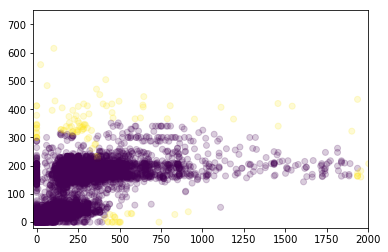

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

sample = pandas_df.sample(10000)

plt.scatter(sample['revenue'], sample['tax'], c=sample['outlier'], alpha=.2)
plt.gca().set_xlim(-20, 2000)
plt.gca().set_ylim(-20, 750)

Looks just the same!

### Appendix: saving models

Just like in sklearn, we can save learned models so that we can share, import or deploy them. In this case we have an additional perk over sklearn: we can use the saved models in pyspark, but also in Scala or Java-based Spark applications. R is trickier, but it should be coming at some point.

In [66]:
km_model.save('my_kmeans_model')

In [68]:
from pyspark.ml.clustering import KMeansModel

loaded_model = KMeansModel.load('my_kmeans_model')

In [70]:
loaded_model.transform(newdf)

DataFrame[revenue: double, tax: double, features: vector, prediction: int]

In [74]:
outliered.write.mode('overwrite').csv('outliered', header=True, sep='^')

#### Exercise

Turn this analysis into a Spark job (you can find an example in notebook 03).

Upload it to the cluster and run it.